# AT2: Citation Graph Builder, Reference Function and Graph Statistics

Rationale: Due to the limtations of my personal computer, and the more ready access for this document, this was conducted via Google Colab using a pip environment. The difference there

## 1. Defining the Citation Matching function:
This specifically deals with downloading the custom Aho-Corasick string mathcing algorithim that we will use for constructing of the fast and efficient graph. This allows us to build the document in a much more efficient manner.

In [ ]:
!pip install pyahocorasick
!pip install tqdm
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.3 MB/s eta 0:00:00


Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

primary_folder= "/content/drive/raw/primary_nsw"
second_folder= "/content/drive/raw/secondary_nsw"

In [ ]:
import networkx as nx
import random

# Parameters
num_nodes = 50
num_edges = 100

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(range(num_nodes))

# Randomly add edges (avoid self-loops)
edges = set()
while len(edges) < num_edges:
    src = random.randint(0, num_nodes - 1)
    dst = random.randint(0, num_nodes - 1)
    if src != dst:
        edges.add((src, dst))

G.add_edges_from(edges)

# Optional: add random weights or labels
for (u, v) in G.edges():
    G[u][v]['weight'] = round(random.uniform(0.1, 1.0), 2)

# Print summary
print(f"Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Save to file
nx.write_graphml(G, "test_graph.graphml")
nx.write_gexf(G, "test_graph.gexf")
# save as a pickle
nx.write_gpickle(G, "test_graph.gpickle")

print("Saved as test_graph.graphml and test_graph.gexf")


Graph created: 50 nodes, 100 edges


AttributeError: module 'networkx' has no attribute 'write_gpickle'

## 2. Build Citation Graphs:


In [ ]:
import os
import json
import pandas as pd
import ahocorasick
from tqdm import tqdm

def build_automaton(citations):
    """Build an Aho–Corasick automaton for fast multi-pattern search."""
    A = ahocorasick.Automaton()
    for idx, citation in enumerate(citations):
        if pd.notna(citation) and citation.strip():
            A.add_word(citation.lower(), (idx, citation))
    A.make_automaton()
    return A

def find_citations_in_text_aho(raw_text, automaton, metadata_df):
    """Use Aho–Corasick to find citations in raw text with counts."""
    text = raw_text.lower()
    counts = {}

    for end_idx, (row_idx, citation) in automaton.iter(text):
        counts[citation] = counts.get(citation, 0) + 1

    results = []
    for citation, count in counts.items():
        row = metadata_df.loc[metadata_df['cleaned_citations'].str.lower() == citation.lower()].iloc[0]
        results.append({
            "cited_legislation": citation,
            "citation_count": count,
            "cited_json_reference": row.get("json_reference", None),
            "cited_type": row.get("type", None)
        })

    return results

def process_legislation_folders_with_counts(metadata_csv, primary_folder, secondary_folder, output_csv):
    """
    Process JSON files and output citation counts per document.
    Each row represents: Document X cited Document Y exactly N times.
    """
    metadata_df = pd.read_csv(metadata_csv, encoding='utf-8')
    citations = metadata_df['cleaned_citations'].dropna().astype(str).tolist()

    automaton = build_automaton(citations)
    all_results = []

    for folder, leg_type in [(primary_folder, "primary_legislation"),
                              (secondary_folder, "secondary_legislation")]:
        folder = str(folder)  # 👈 ensures Path or str both work
        json_files = [f for f in os.listdir(folder) if f.endswith(".json")]

        for fname in tqdm(json_files, desc=f"Processing {leg_type}", unit="file"):
            fpath = os.path.join(folder, fname)
            try:
                with open(fpath, "r", encoding="utf-8") as f:
                    data = json.load(f)

                raw_text = data.get("text", "")

                # Get the source document's metadata
                source_doc = metadata_df[metadata_df['json_reference'] == fname]
                if source_doc.empty:
                    source_citation = fname  # fallback
                else:
                    source_citation = source_doc.iloc[0]['cleaned_citations']

                matches = find_citations_in_text_aho(raw_text, automaton, metadata_df)

                for m in matches:
                    m["source_document"] = source_citation
                    m["source_json_file"] = fname
                    m["source_legislation_type"] = leg_type
                    all_results.append(m)

            except Exception as e:
                print(f"⚠️ Error reading {fpath}: {e}")

    results_df = pd.DataFrame(all_results)

    # Reorder columns for clarity
    col_order = [
        'source_document', 'cited_legislation', 'citation_count',
        'source_json_file', 'cited_json_reference',
        'source_legislation_type', 'cited_type'
    ]
    results_df = results_df[[c for c in col_order if c in results_df.columns]]

    results_df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"\n✅ Citation network data saved to {output_csv}")

    return results_df


Function to count citations based on a primary and secondary legislation folder.

In [ ]:
def count_citation(metadata_csv, primary_folder, secondary_folder, output_csv):
    """
    Process JSON files and output citation counts per document.
    Each row represents: Document X cited Document Y exactly N times.
    """
    metadata_df = pd.read_csv(metadata_csv, encoding='utf-8')
    citations = metadata_df['cleaned_citations'].dropna().astype(str).tolist()

    automaton = build_automaton(citations)
    all_results = []

    for folder, leg_type in [(primary_folder, "primary_legislation"),
                              (secondary_folder, "secondary_legislation")]:
        folder = str(folder)
        json_files = [f for f in os.listdir(folder) if f.endswith(".json")]

        for fname in tqdm(json_files, desc=f"Processing {leg_type}", unit="file"):
            fpath = os.path.join(folder, fname)
            try:
                with open(fpath, "r", encoding="utf-8") as f:
                    data = json.load(f)

                raw_text = data.get("text", "")

                # Get the source document's metadata
                source_doc = metadata_df[metadata_df['json_reference'] == fname]
                if source_doc.empty:
                    source_citation = fname  # fallback
                else:
                    source_citation = source_doc.iloc[0]['cleaned_citations']

                matches = find_citations_in_text_aho(raw_text, automaton, metadata_df)

                for m in matches:
                    m["source_document"] = source_citation
                    m["source_json_file"] = fname
                    m["source_legislation_type"] = leg_type
                    all_results.append(m)

            except Exception as e:
                print(f"⚠️ Error reading {fpath}: {e}")

    results_df = pd.DataFrame(all_results)

    # Reorder columns for clarity
    col_order = [
        'source_document', 'cited_legislation', 'citation_count',
        'source_json_file', 'cited_json_reference',
        'source_legislation_type', 'cited_type'
    ]
    results_df = results_df[[c for c in col_order if c in results_df.columns]]

    results_df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"\n✅ Citation network data saved to {output_csv}")

    return results_df


## 3.  Unit Test Cases for Matching Functions:

To improve the matching of legislation, we had to make the following changes with the reference text


Howverm

Test JSON for the applicability of the function

In [ ]:
json_test = {
  "version_id": "nsw_legislation:2018-07-01/act-1990-019",
  "type": "primary_legislation",
  "jurisdiction": "new_south_wales",
  "source": "nsw_legislation",
  "mime": "text/html",
  "date": "2018-07-01 00:00:00",
  "citation": "Coal Ownership (Restitution) Act 1990 (NSW)",
  "url": "https://legislation.nsw.gov.au/view/whole/html/inforce/2018-07-01/act-1990-019",
  "when_scraped": "2024-09-13T22:44:39.518856+10:00",
  "text": "Coal Ownership (Restitution) Act 1990 No 19\n\nAn Act to provide for the restitution of certain coal acquired by the Crown as a result of the operation of the Coal Acquisition Act 1981 and to provide for related matters.\n\n1 Name of Act\n    This Act may be cited as the Coal Ownership (Restitution) Act 1990.\n\n2 Commencement\n    This Act commences on a day or days to be appointed by proclamation.\n\n3 Definitions\n    In this Act:\n    coal has the same meaning as in the Coal Acquisition Act 1981.\n    coal to which this Act applies means coal that:\n        (a) was vested in the Crown by the operation of section 5 of the Coal Acquisition Act 1981, and\n        (b) on 1 January 1986, was located in land outside a colliery holding.\n    colliery holding has the same meaning as in the Mining Act 1992.\n    Compensation Arrangements means the Coal Acquisition (Compensation) Arrangements 1985.\n    Compensation Board means the New South Wales Coal Compensation Board established under the Compensation Arrangements.\n    eligible claimant means a person who has made a claim for compensation in accordance with the Compensation Arrangements and whose claim has been allowed by the Compensation Board, either before or after the commencement of this section, or:\n        (a) if such a person has died—means the person's legal personal representative, or\n        (b) if such a person is a protected person within the meaning of the NSW Trustee and Guardian Act 2009—means the manager of the person's estate under that Act, or\n        (c) if such a person is an insolvent under administration—means the trustee in bankruptcy of the person's estate, or\n        (d) if such a person is a minor—means the minor's next friend, or\n        (e) if such a person was a body corporate, whether a company or not, which has been dissolved and the property of that body is, by law, vested in a specified person—means that specified person.\n    insolvent under administration means a person who:\n        (a) under the Bankruptcy Act 1966 of the Commonwealth or the law of an external Territory of the Commonwealth, is a bankrupt in respect of a bankruptcy from which the person has not been discharged, or\n        (b) under the law of a country other than Australia or the law of an external Territory of the Commonwealth, has the status of an undischarged bankrupt,\n    and includes:\n        (c) a person who has executed a deed of arrangement under Part X of the Bankruptcy Act 1966 of the Commonwealth, or under the corresponding provisions of the law of an external Territory of the Commonwealth or of the law of a country other than Australia, where the terms of the deed have not been fully complied with, and\n        (d) a person whose creditors have accepted a composition under Part X of the Bankruptcy Act 1966 of the Commonwealth, or under the corresponding provisions of the law of an external Territory of the Commonwealth or of the law of a country other than Australia, where a final payment has not been made under that composition.\n\n4 Power of the Minister to grant coal in accordance with this Act\n        (1) The Minister may, in accordance with this Act, grant to eligible claimants coal to which this Act applies.\n        (2) The Minister may exercise the power conferred by this section only on the recommendation of the Compensation Board.\n        (3) Coal granted under this Act is to be granted for an estate in fee simple.\n        (4) The Crown Land Management Act 2016 applies to the disposal of coal under this Act only to the extent (if any) that the regulations provide.\n\n5 Eligible claimant may apply for restitution of ownership of coal to which this Act applies\n        (1) If coal to which this Act applies was, immediately before 1 January 1982, owned by an eligible claimant or a person through whom the claimant claims, the claimant may make an application to the Compensation Board requesting the Board to make a recommendation to the Minister that the ownership of the coal be restored to the claimant.\n        (2) An application under this section must:\n            (a) be made in the manner and within the period prescribed by the regulations, and\n            (b) contain the information so prescribed, and\n            (c) be accompanied by any documents of a kind so prescribed.\n        (3) As soon as practicable after such an application is received by the Compensation Board, the Board must inquire into the application and make a report of its findings to the Minister, together with a recommendation as to whether or not the application should be granted.\n        (4) If:\n            (a) 2 or more eligible claimants have received or would, but for this Act, be entitled to receive compensation under the Compensation Arrangements for or in respect of the same coal, and\n            (b) any of those claimants has made an application under this section,\n        the Compensation Board may reject the application.\n\n6 Eligible claimant must refund compensation\n        (1) The Minister must not grant to an eligible claimant coal to which this Act applies unless the claimant has refunded to the Compensation Board any amount of compensation paid to the claimant, or a person through whom the claimant claims, by that Board in respect of the acquisition of the coal by the Crown under the Coal Acquisition Act 1981.\n        (2) (Repealed)\n\n7 Decision of Minister not to be questioned except in limited circumstances\n        (1) A decision as to whether or not coal should be granted under this Act is, subject to this Act, in the absolute discretion of the Minister.\n        (1A) Without limiting subsection (1):\n            (a) nothing in this Act, or any recommendation under this Act, requires the Minister to grant coal to eligible claimants, and\n            (b) in particular, the Minister may refuse to grant coal to an eligible claimant if of the opinion that the Crown would lose significant revenue were the coal to cease to be vested in the Crown.\n        (2) A court has no jurisdiction to question a decision of the Minister, or a recommendation of the Compensation Board, under this Act, except on the ground of lack of procedural fairness.\n\n8 Power of the Minister to delegate functions under this Act\n    The Minister may, by instrument in writing, delegate to a specified person or a person holding a specified office any of the Minister's functions under this Act, other than this power of delegation.\n\n9 Regulations\n        (1) The Governor may make regulations, not inconsistent with this Act, for or with respect to any matter that by this Act is required or permitted to be prescribed or that is necessary or convenient to be prescribed for carrying out or giving effect to this Act.\n        (2) In particular, the regulations may make provision for or with respect to the following:\n            (a) the information to be provided in applications under this Act and in documents required to accompany those applications,\n            (b) the period within which such applications must be made,\n            (c) the procedure for determining of such applications,\n            (d) the factors to be taken into account in determining such applications.\n\n10 (Repealed)"
}

In [ ]:
metadata = pd.read_csv('cleaned_citation.csv')

The display of the contents of the cleaned_citation:

In [ ]:
print(cleaned_citation.head())

   Unnamed: 0                                           citation  \
0           0  Motor Accident Injuries Regulation 2017 (2017-...   
1           1  University of Newcastle By-law 2017 (2017-84) ...   
2           2  Forbes Local Environmental Plan 2013 (2013-428...   
3           3  Insurance Premiums Order 2015–2016 (2015-281) ...   
4           4  Weapons Prohibition Regulation 2017 (2017-456)...   

              date      json_reference     jurisdiction       mime  \
0  22/09/2023 0:00  doc_1000_1000.json  new_south_wales  text/html   
1  17/03/2017 0:00  doc_1001_1001.json  new_south_wales  text/html   
2  22/03/2024 0:00  doc_1002_1002.json  new_south_wales  text/html   
3   5/06/2015 0:00  doc_1006_1006.json  new_south_wales  text/html   
4   1/07/2021 0:00  doc_1007_1007.json  new_south_wales  text/html   

            source                   type  \
0  nsw_legislation  secondary_legislation   
1  nsw_legislation  secondary_legislation   
2  nsw_legislation  secondary_legis

In [ ]:
cleaned_cite = metadata['cleaned_citations'].tolist()
print(cleaned_cite)

['Motor Accident Injuries Regulation 2017', 'University of Newcastle By-law 2017', 'Forbes Local Environmental Plan 2013', 'Insurance Premiums Order 2015–2016', 'Weapons Prohibition Regulation 2017', 'Dungog Local Environmental Plan 2014', 'Police Superannuation Regulation 2020', 'Fines Regulation 2020', 'Financial Sector Reform (Savings and Transitional) Regulation 1999', 'Cobar Local Environmental Plan 2012', 'Crimes (Sentencing Procedure) Regulation 2024', 'Blacktown Local Environmental Plan 2015', 'Coal Industry Regulation 2020', 'Road Obstructions (Special Provisions) Regulation 1990', 'Anzac Memorial (Building) By-laws 1937', 'Gas and Electricity (Consumer Safety) Regulation 2018', 'Sheriff Regulation 2021', 'Insurance Premiums Order (July–December) 2005', 'Racing Appeals Tribunal Regulation 2024', 'Fisheries Management (Ocean Hauling Share Management Plan) Regulation 2006', 'Trustee Companies Regulation 2022', 'Narrandera Local Environmental Plan 2013', 'Carrathool Local Environ

In [ ]:
auto = build_automaton(cleaned_cite)

Creation of the blank citation network csv.

In [ ]:

# Define the required columns
col_order = [
    'source_document',
    'cited_legislation',
    'citation_count',
    'source_json_file',
    'cited_json_reference',
    'source_legislation_type',
    'cited_type'
]

# --- Option 1: Create a completely blank CSV ---
blank_df = pd.DataFrame(columns=col_order)
blank_df.to_csv("blank_citation_network.csv", index=False, encoding="utf-8")
print("✅ Blank CSV created: blank_citation_network.csv")

✅ Blank CSV created: blank_citation_network.csv


The reading of the cleaned citations, which have the cleaned up labels. The cleaning methods were:
1. Removing (NSW) from all present laws.
2. Removing the times amended for the given document
3. This leaves the documents left for each of the given references.

In [ ]:
meta_df = pd.read_csv('cleaned_citation.csv')

In [ ]:
citation_test = find_citations_in_text_aho(json_test["text"],auto,meta_df)

In [ ]:
print(citation_test)

[{'cited_legislation': 'Encroachment of Buildings Act 1922', 'citation_count': 2, 'cited_json_reference': 'doc_18_18.json', 'cited_type': 'primary_legislation'}, {'cited_legislation': 'Real Property Act 1900', 'citation_count': 4, 'cited_json_reference': 'doc_1081_1081.json', 'cited_type': 'primary_legislation'}, {'cited_legislation': 'Surveying and Spatial Information Act 2002', 'citation_count': 2, 'cited_json_reference': 'doc_1440_1440.json', 'cited_type': 'primary_legislation'}]


Mounting of the Google files;

In [ ]:
# Mount Google Drive first if not already
from google.colab import drive
drive.mount("/content/drive")

# Use plain strings
primary_folder = "/content/drive/raw/primary_nsw"
second_folder  = "/content/drive/raw/secondary_nsw"

# OR, with pathlib
from pathlib import Path
base_dir = Path("/content/drive/raw")
primary_folder = base_dir / "primary_nsw"
second_folder  = base_dir / "secondary_nsw"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The generation of the files, based upon downloaded documents from the primary_nsw and secondary_nsw legislation JSON packets.

In [ ]:
network_cites = count_citation(
    metadata_csv="cleaned_citation.csv",
    primary_folder="/content/drive/MyDrive/raw/primary_nsw",
    secondary_folder="/content/drive/MyDrive/raw/secondary_nsw",
    output_csv="blank_citation_network.csv"
)


Processing secondary_legislation: 100%|██████████| 798/798 [00:47<00:00, 16.78file/s]



✅ Citation network data saved to blank_citation_network.csv


Summarisation of the Counted Network Citations:
Explained Columns:
1. source_document: Details the source document for the citation
2. cited_legislation: Then number of citations seen inside a given legislation
3. citation_count: The number of citations in a given text.
4. soruce_josn_file: The soruce of the intial citation
5. cited_json_reference: The source of the linked_citation
6. source_legislation_type: The type of legislation used in this given document either primary or secondary legislation.

In [ ]:
print(network_cites)

                             source_document  \
0                   Motor Accidents Act 1988   
1                   Motor Accidents Act 1988   
2                   Motor Accidents Act 1988   
3                   Motor Accidents Act 1988   
4                   Motor Accidents Act 1988   
...                                      ...   
23964  Justices of the Peace Regulation 2020   
23965  Justices of the Peace Regulation 2020   
23966  Justices of the Peace Regulation 2020   
23967  Justices of the Peace Regulation 2020   
23968  Justices of the Peace Regulation 2020   

                                  cited_legislation  citation_count  \
0                          Motor Accidents Act 1988               9   
1             Motor Accidents Compensation Act 1999              10   
2                  Motor Accident Injuries Act 2017               3   
3      State Insurance and Care Governance Act 2015               1   
4                      Recreation Vehicles Act 1983               1 

## 4. Full Code to Construct the Citation Graph:
This combines the concepts above to construct the full citation graph. The file "Graph" is then ideally converted into our specicific code base for each of the given metrics used for the case.

In [ ]:
import networkx as nx
def build_citation_graph(citation_df):
    """
    Build a weighted, directional graph from citation DataFrame.

    Args:
        citation_df: DataFrame with columns:
            - source_document: citing document
            - cited_legislation: cited document
            - citation_count: number of citations (edge weight)
            - source_legislation_type: type of source document
            - cited_type: type of cited document

    Returns:
        G: NetworkX DiGraph with weighted edges
    """
    G = nx.DiGraph()

    print("\n🔨 Building citation graph...")

    # Add edges with weights (citation counts)
    for _, row in tqdm(citation_df.iterrows(), total=len(citation_df), desc="Adding edges"):
        source = row['source_document']
        target = row['cited_legislation']
        weight = row['citation_count']

        # Skip self-citations if any
        if source == target:
            continue

        # If edge already exists, add to the weight (shouldn't happen with your data, but safe)
        if G.has_edge(source, target):
            G[source][target]['weight'] += weight
        else:
            G.add_edge(source, target, weight=weight)

        # Add node attributes
        if source not in G.nodes or 'type' not in G.nodes[source]:
            G.nodes[source]['type'] = row.get('source_legislation_type', 'unknown')
            G.nodes[source]['json_file'] = row.get('source_json_file', '')

        if target not in G.nodes or 'type' not in G.nodes[target]:
            G.nodes[target]['type'] = row.get('cited_type', 'unknown')
            G.nodes[target]['json_file'] = row.get('cited_json_reference', '')

    print(f"\n📊 Graph Statistics:")
    print(f"   Nodes (documents): {G.number_of_nodes():,}")
    print(f"   Edges (citations): {G.number_of_edges():,}")
    print(f"   Total citation count: {sum(d['weight'] for _, _, d in G.edges(data=True)):,}")
    print(f"   Average citations per edge: {sum(d['weight'] for _, _, d in G.edges(data=True)) / G.number_of_edges():.2f}")

    # Count by type
    node_types = {}
    for node, data in G.nodes(data=True):
        node_type = data.get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1

    print(f"\n   Node Types:")
    for node_type, count in node_types.items():
        print(f"   - {node_type}: {count:,}")

    return G

Construction of the unifled citation graph with primary and secondary legislation, whilst giving summary statistics for each.

In [ ]:
Graph = build_citation_graph(network_cites)


🔨 Building citation graph...


Adding edges: 100%|██████████| 23969/23969 [00:01<00:00, 16192.55it/s]


📊 Graph Statistics:
   Nodes (documents): 1,665
   Edges (citations): 22,306
   Total citation count: 62,566
   Average citations per edge: 2.80

   Node Types:
   - primary_legislation: 884
   - secondary_legislation: 781


Graph software for visualisng grpah construction

In [ ]:
def visualize_graph(G, output_path='citation_graph.png', layout='spring',
                   node_size_by='pagerank', top_n_nodes=100, figsize=(24, 20)):
    """
    Visualize the citation network.

    Args:
        G: NetworkX graph
        output_path: where to save the visualization
        layout: 'spring', 'circular', 'kamada_kawai'
        node_size_by: 'in_degree', 'out_degree', 'pagerank', or 'betweenness'
        top_n_nodes: only show top N most connected nodes for clarity
        figsize: figure size tuple
    """
    print(f"\n🎨 Creating visualization...")

    # Filter to top N nodes if graph is large
    if G.number_of_nodes() > top_n_nodes:
        print(f"   Filtering to top {top_n_nodes} nodes...")
        if node_size_by == 'in_degree':
            degrees = dict(G.in_degree(weight='weight'))
        elif node_size_by == 'out_degree':
            degrees = dict(G.out_degree(weight='weight'))
        elif node_size_by == 'betweenness':
            degrees = nx.betweenness_centrality(G, weight='weight')
        else:  # pagerank
            degrees = nx.pagerank(G, weight='weight')

        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n_nodes]
        top_node_names = [n[0] for n in top_nodes]
        G_sub = G.subgraph(top_node_names).copy()
    else:
        G_sub = G

    print(f"   Computing layout ({layout})...")
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G_sub, k=1/np.sqrt(G_sub.number_of_nodes()), iterations=50, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G_sub)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_sub)
    else:
        pos = nx.spring_layout(G_sub, seed=42)

    # Calculate node sizes
    print(f"   Calculating node sizes by {node_size_by}...")
    if node_size_by == 'in_degree':
        node_sizes = [G_sub.in_degree(n, weight='weight') * 10 + 200 for n in G_sub.nodes()]
    elif node_size_by == 'out_degree':
        node_sizes = [G_sub.out_degree(n, weight='weight') * 10 + 200 for n in G_sub.nodes()]
    elif node_size_by == 'betweenness':
        bc = nx.betweenness_centrality(G_sub, weight='weight')
        node_sizes = [bc[n] * 50000 + 200 for n in G_sub.nodes()]
    else:  # pagerank
        pr = nx.pagerank(G_sub, weight='weight')
        max_pr = max(pr.values())
        node_sizes = [pr[n] / max_pr * 2000 + 200 for n in G_sub.nodes()]

    # Node colors by type
    print(f"   Setting colors by legislation type...")
    node_colors = []
    for n in G_sub.nodes():
        node_type = G_sub.nodes[n].get('type', 'unknown')
        if node_type == 'primary_legislation':
            node_colors.append('#3498db')  # blue
        elif node_type == 'secondary_legislation':
            node_colors.append('#e74c3c')  # red
        else:
            node_colors.append('#95a5a6')  # gray

    # Create figure
    print(f"   Rendering graph...")
    plt.figure(figsize=figsize)

    # Draw edges with varying thickness
    edge_weights = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
    if edge_weights:
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        # Normalize edge widths
        edge_widths = [(w - min_weight) / (max_weight - min_weight + 1) * 4 + 0.5 for w in edge_weights]
    else:
        edge_widths = [1.0]

    nx.draw_networkx_edges(G_sub, pos, width=edge_widths, alpha=0.2,
                          edge_color='#34495e', arrows=True, arrowsize=15,
                          arrowstyle='->', connectionstyle='arc3,rad=0.1')

    # Draw nodes
    nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes,
                          node_color=node_colors, alpha=0.9,
                          edgecolors='white', linewidths=2)

    # Draw labels (only for larger nodes)
    if len(G_sub.nodes()) <= 50:
        nx.draw_networkx_labels(G_sub, pos, font_size=7, font_weight='bold',
                               font_family='sans-serif')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3498db', label='Primary Legislation'),
        Patch(facecolor='#e74c3c', label='Secondary Legislation')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

    plt.title(f"NSW Legislation Citation Network\n(Top {len(G_sub.nodes())} nodes by {node_size_by})",
             fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   ✅ Visualization saved: {output_path}")
    plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
visualize_graph(Graph, top_n_nodes=2000)


🎨 Creating visualization...
   Computing layout (spring)...
   Calculating node sizes by pagerank...
   Setting colors by legislation type...
   Rendering graph...
   ✅ Visualization saved: citation_graph.png


In [ ]:
nx.write_graphml(Graph, "network_cites.graphml")

In [ ]:

nx.write_gpickle(Graph, 'citation_graph.gpickle')

AttributeError: module 'networkx' has no attribute 'write_gpickle'

In [ ]:
import pickle
with open('citation_graph.pkl', 'wb') as f:
    pickle.dump(Graph, f)

## 5. Graph Summarisation Statistics:

In [1]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt

def extract_top_20_nodes(graph_file):
    """
    Load a NetworkX graph from a pickle file and extract the top 20 highest connected nodes.

    Parameters:
    graph_file (str): Path to the pickle file containing the NetworkX graph

    Returns:
    tuple: (subgraph, top_nodes_list)
        - subgraph: NetworkX graph containing only the top 20 nodes and their connections
        - top_nodes_list: List of tuples (node, degree) sorted by degree
    """
    # Load the graph from pickle file
    with open(graph_file, 'rb') as f:
        G = pickle.load(f)

    # Calculate degree for each node
    degree_dict = dict(G.degree())

    # Sort nodes by degree and get top 20
    top_20_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:20]

    # Extract just the node names
    top_node_names = [node for node, degree in top_20_nodes]

    # Create subgraph with only top 20 nodes
    subgraph = G.subgraph(top_node_names).copy()

    return subgraph, top_20_nodes

def visualize_network(subgraph, top_nodes_list, save_path=None):
    """
    Visualize the network graph of top 20 connected nodes.

    Parameters:
    subgraph (nx.Graph): NetworkX subgraph to visualize
    top_nodes_list (list): List of tuples (node, degree) for labeling
    save_path (str, optional): Path to save the figure. If None, displays the plot.
    """
    # Create figure with larger size
    plt.figure(figsize=(16, 12))

    # Use spring layout for better visualization
    pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)

    # Calculate node sizes based on degree
    node_sizes = [degree * 100 for node, degree in top_nodes_list]

    # Draw the network
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, width=1, edge_color='gray')
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,
                          node_color='lightblue', edgecolors='darkblue', linewidths=2)
    nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

    # Add title
    plt.title('Top 20 Most Connected Nodes in Citation Graph',
             fontsize=16, fontweight='bold', pad=20)

    # Remove axes
    plt.axis('off')
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {save_path}")
    else:
        plt.show()

def print_node_statistics(top_nodes_list):
    """
    Print statistics about the top 20 nodes.

    Parameters:
    top_nodes_list (list): List of tuples (node, degree)
    """
    print("\n" + "="*60)
    print("TOP 20 MOST CONNECTED NODES")
    print("="*60)
    print(f"{'Rank':<6} {'Node':<30} {'Connections':<12}")
    print("-"*60)

    for i, (node, degree) in enumerate(top_nodes_list, 1):
        print(f"{i:<6} {str(node):<30} {degree:<12}")

    print("="*60)


Generating Statistics for Top 20 Nodes:

In [7]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy file from current directory to your Google Drive
shutil.copy("citation_graph.pkl", "/content/drive/MyDrive/citation_graph.pkl")

print("✅ File uploaded to Google Drive successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File uploaded to Google Drive successfully!


In [11]:
top_nodes_subgraph, top_nodes_list =extract_top_20_nodes("citation_graph.pkl")

In [12]:
print_node_statistics(top_nodes_list)


TOP 20 MOST CONNECTED NODES
Rank   Node                           Connections 
------------------------------------------------------------
1      Interpretation Act 1987        1058        
2      Administrative Arrangements (Minns Ministry—Administration of Acts) Order 2023 742         
3      Administrative Changes Orders 1977–2023 731         
4      Local Government Act 1993      541         
5      Environmental Planning and Assessment Act 1979 452         
6      Allocation of the Administration of Acts 409         
7      National Parks and Wildlife Act 1974 370         
8      Subordinate Legislation Act 1989 367         
9      Crown Land Management Act 2016 363         
10     Water Management Act 2000      347         
11     Government Sector Employment Act 2013 324         
12     Law Enforcement (Powers and Responsibilities) Act 2002 314         
13     Roads Act 1993                 285         
14     Fisheries Management Act 1994  285         
15     Crimes (Administ

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

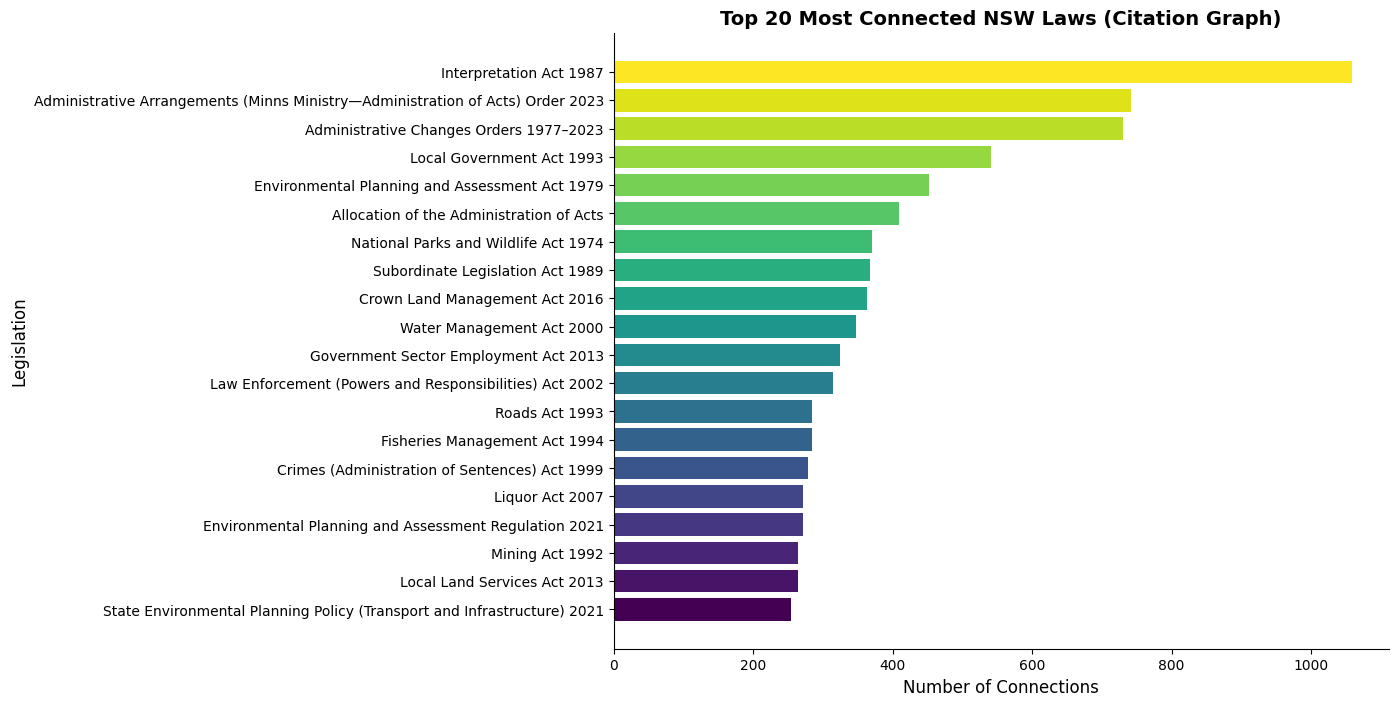

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data
nodes = [
    "Interpretation Act 1987",
    "Administrative Arrangements (Minns Ministry—Administration of Acts) Order 2023",
    "Administrative Changes Orders 1977–2023",
    "Local Government Act 1993",
    "Environmental Planning and Assessment Act 1979",
    "Allocation of the Administration of Acts",
    "National Parks and Wildlife Act 1974",
    "Subordinate Legislation Act 1989",
    "Crown Land Management Act 2016",
    "Water Management Act 2000",
    "Government Sector Employment Act 2013",
    "Law Enforcement (Powers and Responsibilities) Act 2002",
    "Roads Act 1993",
    "Fisheries Management Act 1994",
    "Crimes (Administration of Sentences) Act 1999",
    "Liquor Act 2007",
    "Environmental Planning and Assessment Regulation 2021",
    "Mining Act 1992",
    "Local Land Services Act 2013",
    "State Environmental Planning Policy (Transport and Infrastructure) 2021"
]

connections = [
    1058, 742, 731, 541, 452, 409, 370, 367, 363, 347,
    324, 314, 285, 285, 279, 271, 271, 265, 264, 254
]

# Reverse order so rank 1 is at top
nodes = nodes[::-1]
connections = connections[::-1]

# Create gradient colours
colors = plt.cm.viridis(np.linspace(0, 1, len(nodes)))  # "viridis" = smooth blue→green→yellow
# Alternatives: "plasma", "cividis", "coolwarm", "magma"

# Create the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(nodes, connections, color=colors, edgecolor="none")

plt.xlabel("Number of Connections", fontsize=12)
plt.ylabel("Legislation", fontsize=12)
plt.title("Top 20 Most Connected NSW Laws (Citation Graph)", fontsize=14, fontweight='bold')

# Remove spines for a cleaner look
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(connections), vmax=max(connections)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label("Number of Connections")

plt.tight_layout()
plt.show()

